In [1]:
import warnings

from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from nltk.tokenize.casual import casual_tokenize

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import (
    LatentDirichletAllocation,
    TruncatedSVD,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import (
    SVC,
    LinearSVC,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
)
from skopt import BayesSearchCV
from catboost import CatBoostClassifier


NGRAM_RANGE = (2,2)
N_SAMPLES = 20000
DATASET_PATH = "../data/stemming_post_texts.csv"

In [3]:
corpus_df = pd.read_csv(DATASET_PATH)

In [4]:
corpus_df.shape

(356565, 2)

In [5]:
corpus_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [6]:
train_corpus_df = corpus_df.dropna(subset=["text"]).sample(frac=1).reset_index(drop=True)

In [7]:
if N_SAMPLES:
    train_corpus_df = train_corpus_df.sample(N_SAMPLES)

In [8]:
text_documents_list = train_corpus_df.text.to_list()

In [9]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=NGRAM_RANGE, max_features=10000)

In [10]:
%%time
tf_idf_vectorizer.fit(text_documents_list)

CPU times: total: 5.36 s
Wall time: 5.39 s


TfidfVectorizer(max_features=10000, ngram_range=(2, 2),
                tokenizer=<function casual_tokenize at 0x0000028C84128E50>)

In [11]:
%%time
X = tf_idf_vectorizer.transform(train_corpus_df["text"])
y = train_corpus_df["sentiment"]

CPU times: total: 3.42 s
Wall time: 3.44 s


In [12]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
X.shape

(20000, 10000)

SVD

In [14]:
svd_2_components = TruncatedSVD(n_components=2)

In [15]:
%%time
svd_2_components.fit(X)

CPU times: total: 46.9 ms
Wall time: 63.7 ms


TruncatedSVD()

In [16]:
svd_2_data = svd_2_components.transform(X)

In [17]:
svd_2_data_df = pd.DataFrame(data=svd_2_data, columns=["parameter_1", "parameter_2"])
svd_2_data_df["sentiment"] = y
svd_2_data_df["sentiment"] = svd_2_data_df["sentiment"].replace({-1: "negative", 0: "neutral", 1: "positive"})

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

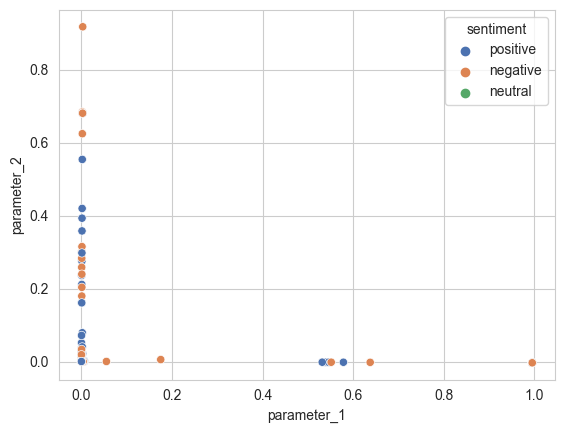

In [18]:
sns.scatterplot(data=svd_2_data_df, x="parameter_1", y="parameter_2",  hue="sentiment", palette="deep")

Latent Dirichlet Decomposition

In [19]:
ldia = LatentDirichletAllocation(n_components=2, learning_method="batch")

In [20]:
%%time
ldia.fit(X)

CPU times: total: 14.9 s
Wall time: 14.9 s


LatentDirichletAllocation(n_components=2)

In [21]:
ldia_2_data = ldia.transform(X)

In [22]:
ldia_2_data_df = pd.DataFrame(data=ldia_2_data, columns=["parameter_1", "parameter_2"])
ldia_2_data_df["sentiment"] = y
ldia_2_data_df["sentiment"] = ldia_2_data_df["sentiment"].replace({-1: "negative", 0: "neutral", 1: "positive"})

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

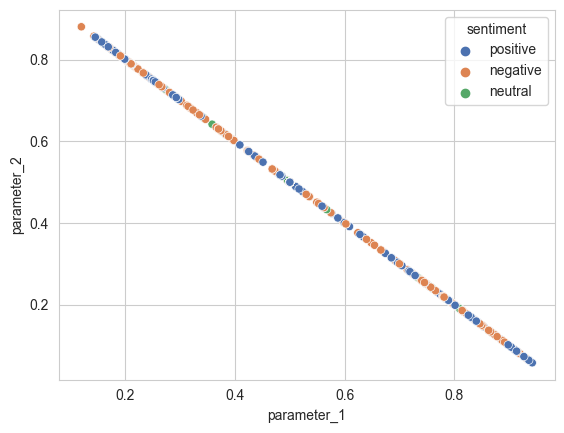

In [23]:
sns.scatterplot(data=ldia_2_data_df, x="parameter_1", y="parameter_2",  hue="sentiment", palette="deep")

K-means

In [24]:
k_means = KMeans(n_clusters=3, init="k-means++", max_iter=150)

In [25]:
%%time
k_means.fit(X)

CPU times: total: 4.5 s
Wall time: 1.33 s


KMeans(max_iter=150, n_clusters=3)

In [26]:
k_means_predictions = k_means.predict(X)

In [27]:
k_means_df = pd.DataFrame(data=svd_2_data, columns=["parameter_1", "parameter_2"])
k_means_df["cluster"] = k_means_predictions
k_means_df["cluster"] = k_means_df["cluster"]

In [28]:
k_means_centers = pd.DataFrame(data=svd_2_components.transform(k_means.cluster_centers_), columns=["parameter_1", "parameter_2"])

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

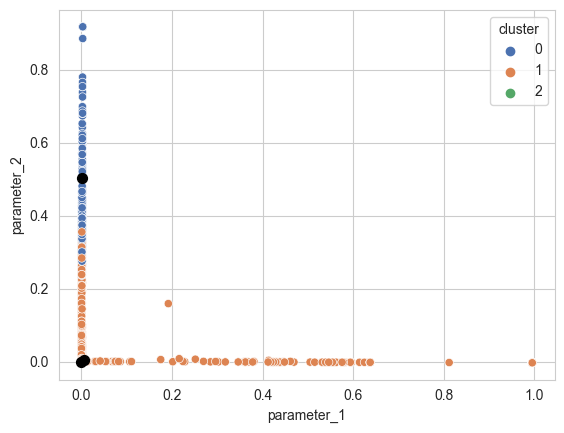

In [29]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=k_means_df, x="parameter_1", y="parameter_2",  hue="cluster", palette="deep")
k_means_centers.plot.scatter(x="parameter_1", y="parameter_2", ax=ax, s=50, color="black")

In [30]:
print(f"Однородность кластеров для K-средних: {homogeneity_score(y, k_means_df.cluster)}")
print(f"Полнота кластеров для K-средних: {completeness_score(y, k_means_df.cluster)}")
print(classification_report(y_encoded, k_means_df.cluster))

Однородность кластеров для K-средних: 0.0029368344066324947
Полнота кластеров для K-средних: 0.04288694442354964
              precision    recall  f1-score   support

           0       0.75      0.02      0.04      8772
           1       0.08      1.00      0.14      1490
           2       0.50      0.00      0.00      9738

    accuracy                           0.08     20000
   macro avg       0.44      0.34      0.06     20000
weighted avg       0.58      0.08      0.03     20000



Разделение на обучающие и тестовые данные

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Наивный байесовский классификатор

In [32]:
naive_bayes_bcv = BayesSearchCV(estimator=MultinomialNB(), search_spaces={
    "alpha": [x / 10 for x in range(0, 11, 1)],
    "fit_prior": [True, False],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [33]:
%%time
naive_bayes_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=MultinomialNB(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                       0.8, 0.9, 1.0],
                             'fit_prior': [True, False]},
              verbose=2)

In [34]:
naive_bayes_model = naive_bayes_bcv.best_estimator_

In [35]:
naive_bayes_model

MultinomialNB(alpha=0.2)

In [36]:
y_pred = naive_bayes_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.58      0.31      0.41      1767
     neutral       0.47      0.29      0.36       282
    positive       0.58      0.85      0.69      1951

    accuracy                           0.57      4000
   macro avg       0.54      0.48      0.48      4000
weighted avg       0.57      0.57      0.54      4000



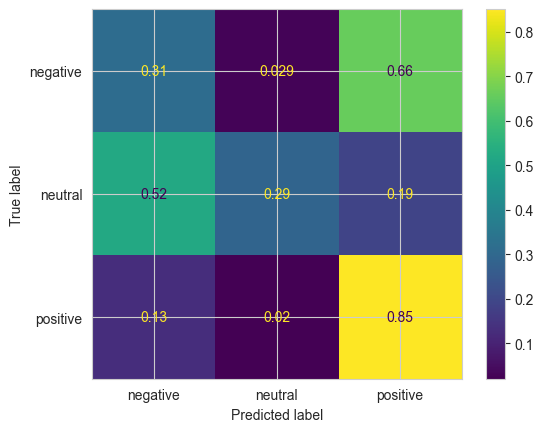

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [38]:
print(np.mean(cross_val_score(naive_bayes_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

0.4908720377251775


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


SVC

In [39]:
%%time

svc_bcv = BayesSearchCV(estimator=SVC(), search_spaces={
    "C": [x / 10 for x in range(1, 11, 1)],
    "max_iter": [x for x in range(10, 1000, 10)],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

svc_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=SVC(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                             'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]},
              verbose=2)

In [40]:
svc = svc_bcv.best_estimator_
svc

SVC(max_iter=810)

In [41]:
%%time
svc.fit(X_train, y_train)

CPU times: total: 1.41 s
Wall time: 1.4 s


SVC(max_iter=810)

In [42]:
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.41      0.45      0.43      1767
     neutral       0.39      0.34      0.36       282
    positive       0.51      0.47      0.49      1951

    accuracy                           0.46      4000
   macro avg       0.44      0.42      0.43      4000
weighted avg       0.46      0.46      0.46      4000



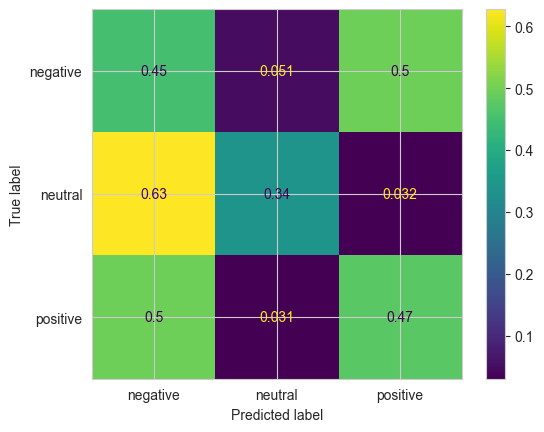

In [43]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [44]:
print(np.mean(cross_val_score(svc, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.42422413717940516


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.3s finished


LinearSVC

In [45]:
%%time

linear_svc_bcv = BayesSearchCV(estimator=LinearSVC(), search_spaces={
    "C": [x / 10 for x in range(1, 11, 1)],
    "max_iter": [x for x in range(10, 1000, 10)],
    "loss": ["hinge", "squared_hinge"],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

linear_svc_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=LinearSVC(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                             'loss': ['hinge', 'squared_hinge'],
                             'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]},
              verbose=2)

In [46]:
linear_svc_model = linear_svc_bcv.best_estimator_
linear_svc_model

LinearSVC(C=0.4, max_iter=930)

In [47]:
%%time
linear_svc_model.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 49 ms


LinearSVC(C=0.4, max_iter=930)

In [48]:
y_pred = linear_svc_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.58      0.31      0.40      1767
     neutral       0.44      0.23      0.30       282
    positive       0.57      0.85      0.68      1951

    accuracy                           0.57      4000
   macro avg       0.53      0.46      0.46      4000
weighted avg       0.56      0.57      0.53      4000



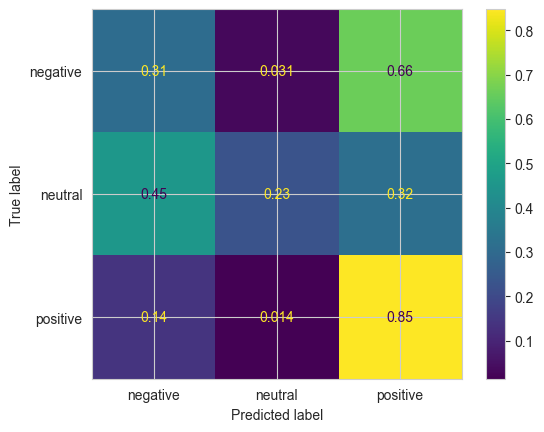

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [50]:
print(np.mean(cross_val_score(linear_svc_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

0.4798234306056403


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Логистическая регрессия

In [51]:
log_reg = LogisticRegression()

In [52]:
%%time
log_reg.fit(X_train, y_train)

CPU times: total: 3.3 s
Wall time: 576 ms


LogisticRegression()

In [53]:
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.57      0.32      0.41      1767
     neutral       0.54      0.09      0.16       282
    positive       0.57      0.86      0.68      1951

    accuracy                           0.57      4000
   macro avg       0.56      0.42      0.42      4000
weighted avg       0.57      0.57      0.53      4000



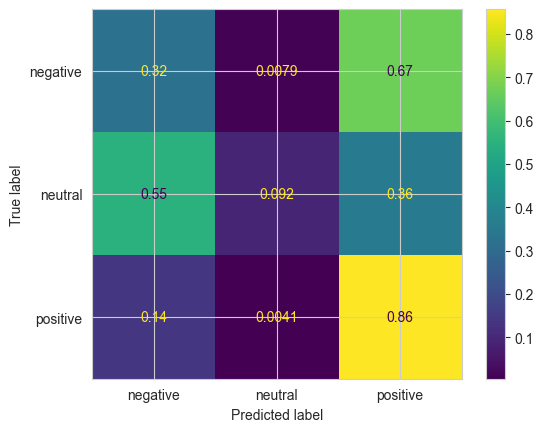

In [54]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [55]:
print(np.mean(cross_val_score(log_reg, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.47315045193191685


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.5s finished


K-ближайших соседей

In [56]:
knn_bcv = BayesSearchCV(estimator=KNeighborsClassifier(), search_spaces={
    "n_neighbors": [n for n in range(1, 21, 1)],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [57]:
%%time
knn_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=KNeighborsClassifier(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13, 14, 15, 16, 17, 18, 19,
                                             20]},
              verbose=2)

In [58]:
knn_model = knn_bcv.best_estimator_

In [59]:
knn_model

KNeighborsClassifier()

In [60]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.48      0.30      0.37      1767
     neutral       0.43      0.01      0.02       282
    positive       0.53      0.78      0.63      1951

    accuracy                           0.51      4000
   macro avg       0.48      0.36      0.34      4000
weighted avg       0.50      0.51      0.47      4000



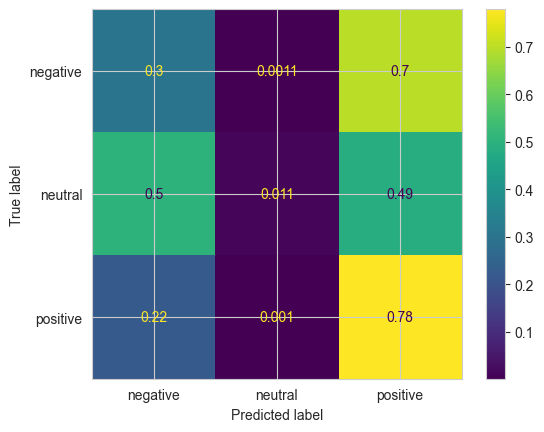

In [61]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [62]:
print(np.mean(cross_val_score(knn_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

0.4294490172391031


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Дерево решений

In [63]:
d_tree_bcv = BayesSearchCV(estimator=DecisionTreeClassifier(), search_spaces={
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [depth for depth in range(2, 500, 10)]
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [64]:
%%time
d_tree_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
              scoring='f1_weighted',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [2, 12, 22, 32, 42, 52, 62, 72, 82,
                                           92, 102, 112, 122, 132, 142, 152,
                                           162, 172, 182, 192, 202, 212, 222,
                                           232, 242, 252, 262, 272, 282, 292, ...],
                             'splitter': ['best', 'random']},
              verbose=2)

In [65]:
d_tree_model = d_tree_bcv.best_estimator_

In [66]:
d_tree_model

DecisionTreeClassifier(max_depth=462, splitter='random')

In [67]:
y_pred = d_tree_model.predict(X_test)
print(classification_report(y_test, d_tree_model.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.65      0.12      0.20      1767
     neutral       0.45      0.32      0.37       282
    positive       0.53      0.94      0.68      1951

    accuracy                           0.54      4000
   macro avg       0.54      0.46      0.42      4000
weighted avg       0.58      0.54      0.45      4000



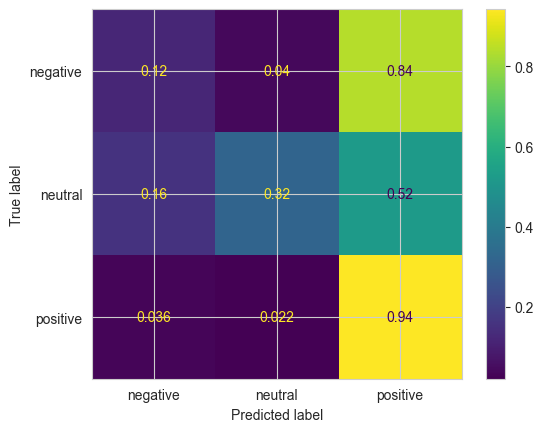

In [68]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [69]:
print(np.mean(cross_val_score(d_tree_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.43042041374604534


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    4.6s finished


Градиентный бустинг (CatBoost)

In [70]:
catboost_model = CatBoostClassifier(
    task_type="GPU",
    iterations=5000,
    od_wait=300,
    od_type="Iter",
    learning_rate=0.5,
    eval_metric="TotalF1",
)

In [71]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2)

In [72]:
catboost_model.fit(x_train_, y_train_, eval_set=(x_val_, y_val_), verbose=100, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3556016	test: 0.3582597	best: 0.3582597 (0)	total: 22.9ms	remaining: 1m 54s
100:	learn: 0.4864017	test: 0.4266689	best: 0.4266689 (100)	total: 1.38s	remaining: 1m 6s
200:	learn: 0.5395648	test: 0.4448242	best: 0.4452646 (194)	total: 2.71s	remaining: 1m 4s
300:	learn: 0.5746086	test: 0.4595332	best: 0.4595332 (297)	total: 4.07s	remaining: 1m 3s
400:	learn: 0.5976008	test: 0.4646569	best: 0.4646569 (400)	total: 5.36s	remaining: 1m 1s
500:	learn: 0.6141918	test: 0.4699256	best: 0.4715329 (489)	total: 6.63s	remaining: 59.6s
600:	learn: 0.6275135	test: 0.4791568	best: 0.4798333 (597)	total: 7.89s	remaining: 57.8s
700:	learn: 0.6402390	test: 0.4821577	best: 0.4821577 (699)	total: 9.16s	remaining: 56.2s
800:	learn: 0.6541023	test: 0.4814066	best: 0.4831185 (737)	total: 10.5s	remaining: 55s
900:	learn: 0.6656694	test: 0.4840260	best: 0.4858336 (860)	total: 11.8s	remaining: 53.7s
1000:	learn: 0.6784125	test: 0.4845895	best: 0.4858336 (860)	total: 13.1s	remaining: 52.2s
1100:	learn: 

In [73]:
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.56      0.26      0.36      1767
     neutral       0.40      0.19      0.26       282
    positive       0.55      0.86      0.68      1951

    accuracy                           0.55      4000
   macro avg       0.50      0.44      0.43      4000
weighted avg       0.55      0.55      0.51      4000



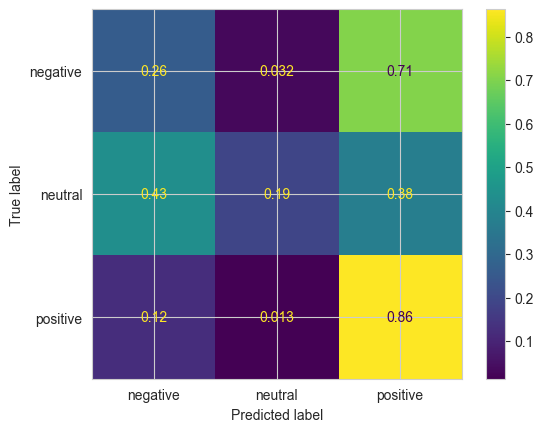

In [74]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()